In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [14]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,SystemMessage

In [15]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model='gpt-4o')

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [16]:
# Define the title generation function
def title_generate(topic: str) -> str:
    """
    Generates a catchy, informative, and creative title for an article based on the given topic.
    
    Args:
        topic (str): The topic or subject for the article.
    
    Returns:
        str: The generated title.
    """
    prompt = f"Generate a catchy, informative, and creative title for an article based on the following topic: {topic}"
    
    response = llm.call_as_tool(
        inputs=[HumanMessage(content=prompt)],
        return_message=True  # Ensure you get the response
    )
    
    title = response.content
    return title

# Define the content creation function
def content_creator(title: str) -> str:
    """
    Generates a detailed and engaging article based on the given title.
    
    Args:
        title (str): The title of the article to generate content for.
    
    Returns:
        str: The generated content for the article.
    """
    prompt = f"Generate a detailed and engaging article based on the following title: {title}"
    
    response = llm.call_as_tool(
        inputs=[HumanMessage(content=prompt)],
        return_message=True  # Ensure you get the response
    )
    
    content = response.content
    return content

In [17]:
tools=[title_generate,content_creator]
llm_with_tools=llm.bind_tools(tools=tools,parallel_tool_calls=False)

In [18]:
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,display

In [23]:
# Initialize the builder for the graph
builder = StateGraph(State)

# Add the LLM node that now uses llm_with_tools
builder.add_node("LLM", llm_with_tools)

# Add the tools as nodes (title_generate and content_creator)
builder.add_node("title_generate", ToolNode([title_generate]))
builder.add_node("content_creator", ToolNode([content_creator]))

# Define the conditional edge based on the tool call from the LLM
builder.add_conditional_edges(
    "LLM", 
    {
        "title_generate": "title_generate",  # If the tool call is 'title_generate', route to the title_generate node
        "content_creator": "content_creator"  # If the tool call is 'content_creator', route to the content_creator node
    }
)

# Define the edges to represent the sequence of the process
builder.add_edge(START, "LLM")  # Start to LLM node

builder.add_edge("LLM", "title_generate")  # LLM to title generation
builder.add_edge("title_generate", "content_creator")  # Title generation to content creation
builder.add_edge("content_creator", "LLM")  # Content creation back to LLM for possible further actions

# End node (if any)
builder.add_edge("LLM", "END")

# Compile the graph
react_graph = builder.compile()

# Display the graph as a Mermaid diagram (assuming you have `mermaid` installed)
display(Image(react_graph.get_graph().draw_mermaid_png()))

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

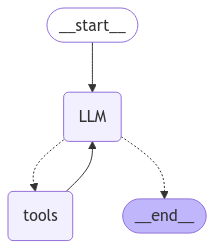

In [28]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4')

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# Define the title generation function
def title_generate(topic: str) -> str:
    """
    Generates a catchy, informative, and creative title for an article based on the given topic.
    
    Args:
        topic (str): The topic or subject for the article.
    
    Returns:
        str: The generated title.
    """
    prompt = f"Generate a catchy, informative, and creative title for an article based on the following topic: {topic}"
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    title = response.content
    return title

# Define the content creation function
def content_creator(title: str) -> str:
    """
    Generates a detailed and engaging article based on the given title.
    
    Args:
        title (str): The title of the article to generate content for.
    
    Returns:
        str: The generated content for the article.
    """
    prompt = f"Generate a detailed and engaging article based on the following title: {title}"
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    content = response.content
    return content

tools = [title_generate, content_creator]
llm_with_tools = llm.bind_tools(tools=tools, parallel_tool_calls=False)

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Initialize the builder for the graph
builder = StateGraph(State)

# Add the LLM node that now uses llm_with_tools
builder.add_node("LLM", llm_with_tools)

# Add the tools as nodes 
builder.add_node("tools",ToolNode(tools))

# Define the conditional edge based on the tool call from the LLM
builder.add_conditional_edges(
    "LLM", 
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

# Define the edges to represent the sequence of the process
builder.add_edge(START, "LLM")  # Start to LLM node
builder.add_edge("tools", "LLM")  # Content creation back to LLM for possible further actions

# Compile the graph
react_graph = builder.compile()

# Display the graph as a Mermaid diagram (assuming you have `mermaid` installed)
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
messages=[HumanMessage(content="Generate a content for topic Machine Learning")]
messages=react_graph.invoke({"messages":messages})
for m in messages["messages"]:
    m.pretty_print()

In [30]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.graph.message import add_messages

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4')

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# Define the tools (title_generate and content_creator remain the same)

tools = [title_generate, content_creator]
llm_with_tools = llm.bind_tools(tools=tools)

from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode

# Initialize the graph
builder = StateGraph(State)

# Define LLM node
def llm_node(state: State):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

builder.add_node("LLM", llm_node)

# Add tools node
tool_node = ToolNode(tools)
builder.add_node("tools", tool_node)

# Define conditional edges
def tools_condition(state: State):
    last_msg = state['messages'][-1]
    if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
        return "tools"
    else:
        return "END"

builder.add_conditional_edges("LLM", tools_condition)

# Define edges
builder.add_edge(START, "LLM")
builder.add_edge("tools", "LLM")  # Loop back to LLM after tool execution

# Compile the graph
react_graph = builder.compile()

# Test the flow
messages = [HumanMessage(content="Generate a content for topic Machine Learning")]
result = react_graph.invoke({"messages": messages})

for msg in result["messages"]:
    print(msg.content)

KeyError: 'branch:LLM:tools_condition:END'